
Our aim is to try to built a QA model that can answer all CORD-19 TASKS. 

This notebook is decomposed of 3 parts: 

    - 1st: Data Processing
    
    - 2nd: QA model
    
    - 3rd: Topic modelling 

# Data Processing
## Necessary Libraries

In [14]:
import numpy as np
import pandas as pd
from datetime import datetime

import glob 
import json 

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
import seaborn as sns 

import sys 
if not sys.warnoptions: 
    import warnings 
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

## Metadata 

In [15]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

path = '../CORD-19-research-challenge/'

In [16]:
metadata_df = pd.read_csv(f'{path}metadata.csv',
                          parse_dates=['publish_time'],
                          dtype={'pubmed_id':str, 'Microsoft Academic Paper ID':str},
                          low_memory=False)

metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47298 entries, 0 to 47297
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   cord_uid                     47298 non-null  object        
 1   sha                          34283 non-null  object        
 2   source_x                     47298 non-null  object        
 3   title                        47140 non-null  object        
 4   doi                          43956 non-null  object        
 5   pmcid                        28038 non-null  object        
 6   pubmed_id                    35409 non-null  object        
 7   license                      47298 non-null  object        
 8   abstract                     39048 non-null  object        
 9   publish_time                 47289 non-null  datetime64[ns]
 10  authors                      45189 non-null  object        
 11  journal                      42894 non-nu

In [17]:
metadata_df = metadata_df[['sha', 'title', 'authors', 'journal', 'publish_time', 'abstract']]
metadata_df = metadata_df[metadata_df.sha.isna()==False]
metadata_df.rename(columns={'sha':'paper_id'}, inplace=True)


In [19]:
# If the number of authors is greater than two, we keep the first one and replace the other by "et al." 
authors = []
for author in metadata_df.authors.astype(str):
    if len(author.split('; ')) > 2:
        authors.append(author.split('; ')[0]+' et al.')
    else:
        authors.append(author)

metadata_df['authors'] = authors
metadata_df['abstract'] = [str(a).replace('Abstract ','') for a in metadata_df.abstract]

metadata_df.head()

,paper_id,title,authors,journal,publish_time,abstract
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva..."
5,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase..."
6,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
7,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W..."
8,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati..."


## Extract the body text of the papers from JSON files

In [20]:
# JSON path
pdf_json = glob.glob(path+'**/pdf_json/*.json', recursive=True)
pmc_json = glob.glob(path+'**/pmc_json/*.json', recursive=True)

print('Lenght of pdf_json is', len(pdf_json))
print('Lenght of pmc_json is', len(pmc_json))

Lenght of pdf_json is 36236
Lenght of pmc_json is 15861


In [21]:
with open(pdf_json[0], mode='r') as file:
     contents = json.loads(file.read())
        
contents.keys()

dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])

In [22]:
%%time
papers_df = pd.DataFrame(columns=['paper_id','body_text'])

for j in range(len(pdf_json)):
    with open(pdf_json[j], mode='r') as file:
        contents = json.loads(file.read())

    papers_df.loc[j,'paper_id'] = contents['paper_id']

    texts = []
    for text in contents['body_text']:
        texts.append(text['text'])
    body_text = '\n '.join(texts)
    papers_df.loc[j,'body_text'] = body_text


CPU times: user 3min 4s, sys: 16.5 s, total: 3min 20s
Wall time: 3min 45s


## Merging the metadata and the body text of the papers

In [23]:
%%time
cord19_df = pd.merge(metadata_df, papers_df, on=['paper_id'], how='inner')
cord19_df.drop_duplicates(['paper_id', 'body_text'], inplace=True)

cord19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32417 entries, 0 to 32424
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   paper_id      32417 non-null  object        
 1   title         32381 non-null  object        
 2   authors       32417 non-null  object        
 3   journal       31003 non-null  object        
 4   publish_time  32417 non-null  datetime64[ns]
 5   abstract      32417 non-null  object        
 6   body_text     32417 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.0+ MB
CPU times: user 4.78 s, sys: 7.99 s, total: 12.8 s
Wall time: 24.2 s


In [24]:
cord19_df.head()

,paper_id,title,authors,journal,publish_time,abstract,body_text
0,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva...","The patient (Fo, ) was a 58 year old mentally retarded white woman, born in a rural area of sout..."
1,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase...","Pathogenesis and Risk Factors J. ROBERT CANTEY, M.D. Charleston, South Carolina Our understandin..."
2,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin...","In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
3,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W...","Respiratory Tract Infections JERROLD J. ELLNER, M.D. Cleveland, CM Pharyngitis, bronchitis, and ..."
4,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati...","A cute bronchitis, an illness frequently encountered by primary-care physicians [1] , is an infl..."


In [25]:
cord19_df.isnull().sum()

paper_id           0
title             36
authors            0
journal         1414
publish_time       0
abstract           0
body_text          0
dtype: int64

## Language detection 

In [29]:
import scispacy
import spacy
import en_core_sci_sm
from spacy_langdetect import LanguageDetector

nlp = spacy.load("en_core_web_sm")
nlp = en_core_sci_sm.load()
nlp.max_length = 1_000_000
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [30]:
%%time
cord19_df['paper_language'] = cord19_df.abstract.apply(lambda x: nlp(str(x[:1000]))._.language['language'])

cord19_df.paper_language.value_counts()

CPU times: user 12min 47s, sys: 1min 20s, total: 14min 8s
Wall time: 14min 26s


en         28030
tl          4032
fr           164
es           157
it            12
de             8
nl             6
pt             3
cy             1
et             1
ro             1
ca             1
UNKNOWN        1
Name: paper_language, dtype: int64

In [31]:
# Keep only the documents with english language 
cord19_df = cord19_df[cord19_df.paper_language=='en'].drop(['paper_language'], axis=1)
cord19_df.isnull().sum()

paper_id           0
title             34
authors            0
journal         1410
publish_time       0
abstract           0
body_text          0
dtype: int64

In [32]:
print(f'The CORD19 dataset contains {cord19_df.shape[0]} papers written in English')

The CORD19 dataset contains 28030 papers written in English


In [53]:
# Save to CSV
#cord19_df.to_csv('../data_processed/cord19_processed.csv', index=False)

## QA model
## Necessary Libraries

In [33]:
import numpy as np
import pandas as pd 
from pathlib import Path, PurePath

import nltk
from nltk.corpus import stopwords
import re
import string
import torch

from rank_bm25 import BM25Okapi #Search engine

pd.options.display.max_colwidth = 100 #Display setting to show more characters in column

### Read the processed data

In [34]:
cord19_df = pd.read_csv('../data_processed/cord19_processed.csv',
                        dtype={'paper_id':str, 'title':str, 'authors':str, 'journal':str, 'abstract':str, 'body_text':str},
                        parse_dates=['publish_time'])
cord19_df.head()

,paper_id,title,authors,journal,publish_time,abstract,body_text
0,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva...","The patient (Fo, ) was a 58 year old mentally retarded white woman, born in a rural area of sout..."
1,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase...","Pathogenesis and Risk Factors J. ROBERT CANTEY, M.D. Charleston, South Carolina Our understandin..."
2,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin...","In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
3,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W...","Respiratory Tract Infections JERROLD J. ELLNER, M.D. Cleveland, CM Pharyngitis, bronchitis, and ..."
4,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati...","A cute bronchitis, an illness frequently encountered by primary-care physicians [1] , is an infl..."


## Preprocessing and Search Engine

In [35]:
# Stop words and extension words
english_stopwords = stopwords.words('english') 
english_stopwords.extend(['_url_','_mention_','_hashtag_','figure','unmanned',
                          'also','use','say','subject','edu','would','say','know',
                          'good','go','get','done','try','many','nice','thank','think',
                          'see','rather','easy','easily','lot','lack','make','want','seem',
                          'run','need','even','right','line','even','also','may','take','come',
                          'year','time','hour','first','last','second','high','new','low'])

# Replace contractions with their longer forms
contraction_mapping = {"u.s.":"america", "u.s":"america", "usa":"america", "u.k.":"england", "u.k":"england", "e-mail":"email",
                       "can't": "cannot", "'cause": "because", "could've": "could have","he'd": "he would","he'll": "he will", 
                       "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't've": "might not have", "must've": "must have",
                       "mustn't've": "must not have", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have",
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have", "we'd":"we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're":"we are", "we've":"we have",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've":"where have", "who'll":"who will", "who'll've":"who will have", "who's":"who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "would've": "would have", "wouldn't've":"would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd've": "you would have"}

# URL, MENTION, HASHTAG 
giant_url_regex= 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
mention_regex  = '@[\w\-]+'
hashtag_regex  = '#[\w\-]+'
space_pattern  = '\s+'

In [36]:
class CovidSearchEngine:
    """
    Simple CovidSearchEngine.
    """
    
    def text_process(self, text):
        
        # Deal with URL, MENTION, HASHTAG
        text = re.sub(space_pattern, ' ', text)
        text = re.sub(giant_url_regex, '_URL_', text)
        text = re.sub(mention_regex, '_MENTION_', text)
        text = re.sub(hashtag_regex, '_HASHTAG_', text)
        
        # Special_character
        text = re.sub(r"\/"," ", text)
        text = re.sub(r"\^"," ^ ", text)
        text = re.sub(r"\+"," + ", text)
        text = re.sub(r"\-"," - ", text)
        text = re.sub(r"\="," = ", text)
        text = re.sub(r"\/"," ", text)
        text = re.sub(r"\^"," ^ ", text)
        text = re.sub(r"\+"," + ", text)
        text = re.sub(r"\-"," - ", text)
        text = re.sub(r"\="," = ", text)
        
        # contraction and punctuation
        text = text.lower()
        text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in nltk.word_tokenize(text)])
        text = text.replace(' .', '.').replace('( ', '(').replace(' )', ')')
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    def text_tokenize(self, text):
        
        # tokenize text
        words = nltk.word_tokenize(text)
        return list(set([word for word in words 
                         if len(word) > 2
                         and not word in english_stopwords
                         and not word.isnumeric() # if word.isalpha()
                        ]))
    
    def preprocess(self, text):
        # Clean and tokenize text input
        return self.text_tokenize(self.text_process(text.lower()))

    def __init__(self, corpus: pd.DataFrame):
        self.corpus = corpus
        self.columns = corpus.columns
        
        raw_search_str = self.corpus.abstract.fillna('') + ' ' \
                            + self.corpus.title.fillna('')
        
        self.index = raw_search_str.apply(self.preprocess).to_frame()
        self.index.columns = ['terms']
        self.index.index = self.corpus.index
        self.bm25 = BM25Okapi(self.index.terms.tolist())
    
    def search(self, query, num):
        """
        Return top `num` results that better match the query
        """
        # obtain scores
        search_terms = self.preprocess(query) 
        doc_scores = self.bm25.get_scores(search_terms)
        
        # sort by scores
        ind = np.argsort(doc_scores)[::-1][:num] 
        
        # select top results and returns
        results = self.corpus.iloc[ind][self.columns]
        results['score'] = doc_scores[ind]
        results = results[results.score > 0]
        return results.reset_index()

In [37]:
%%time
cse = CovidSearchEngine(cord19_df)

CPU times: user 1min 23s, sys: 1.12 s, total: 1min 25s
Wall time: 1min 26s


## Download pre-trained QA model

In [38]:
%%time

import torch
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

# Use GPU for computation, if available 
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use the pre-trained model to get answer to a question 
BERT_SQUAD = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(BERT_SQUAD)
tokenizer = BertTokenizer.from_pretrained(BERT_SQUAD)

model = model.to(torch_device)
model.eval()

print()


CPU times: user 10.5 s, sys: 4.57 s, total: 15.1 s
Wall time: 19.2 s


## Answer questions
### Get the answers

In [39]:
def answer_question(question, context):
    
    # anser question given question and context
    encoded_dict = tokenizer.encode_plus(
                        question, context,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_tensors = 'pt')
    
    input_ids = encoded_dict['input_ids'].to(torch_device)
    token_type_ids = encoded_dict['token_type_ids'].to(torch_device)
    
    start_scores, end_scores = model(input_ids, token_type_ids=token_type_ids)

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores)
    
    answer = tokenizer.convert_tokens_to_string(all_tokens[start_index:end_index+1])
    answer = answer.replace('[CLS]', '')
    return answer

### Tasks and Questions dictionary

In [40]:
cord19_kaggle_questions = {
    "data":[
        {
            "task": "What is known about transmission, incubation, and environmental stability?",
            "questions": [
                "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                "How long is the incubation period for the virus?",
                "Can the virus be transmitted asymptomatically or during the incubation period?",
                "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                "How long can the 2019-nCoV virus remain viable on common surfaces?"
            ]
        },
        {
            "task": "What do we know about COVID-19 risk factors?",
            "questions": [
                "What risk factors contribute to the severity of 2019-nCoV?",
                "How does hypertension affect patients?",
                "How does heart disease affect patients?",
                "How does copd affect patients?",
                "How does smoking affect patients?",
                "How does pregnancy affect patients?",
                "What is the fatality rate of 2019-nCoV?",
                "What public health policies prevent or control the spread of 2019-nCoV?"
            ]
        },
        {
            "task": "What do we know about virus genetics, origin, and evolution?",
            "questions": [
                "Can animals transmit 2019-nCoV?",
                "What animal did 2019-nCoV come from?",
                "What real-time genomic tracking tools exist?",
                "What geographic variations are there in the genome of 2019-nCoV?",
                "What effors are being done in asia to prevent further outbreaks?"
            ]
        },
        {
            "task": "What do we know about vaccines and therapeutics?",
            "questions": [
                "What drugs or therapies are being investigated?",
                "Are anti-inflammatory drugs recommended?"
            ]
        },
        {
            "task": "What do we know about non-pharmaceutical interventions?",
            "questions": [
                "Which non-pharmaceutical interventions limit tramsission?",
                "What are most important barriers to compliance?"
            ]
        },
        {
            "task": "What has been published about medical care?",
            "questions": [
                "How does extracorporeal membrane oxygenation affect 2019-nCoV patients?",
                "What telemedicine and cybercare methods are most effective?",
                "How is artificial intelligence being used in real time health delivery?",
                "What adjunctive or supportive methods can help patients?"
            ]
        },
        {
            "task": "What do we know about diagnostics and surveillance?",
            "questions": [
                "What diagnostic tests (tools) exist or are being developed to detect 2019-nCoV?"
            ]
        },
        {
            "task": "Other interesting questions",
            "questions": [
                "What is the immune system response to 2019-nCoV?",
                "Can personal protective equipment prevent the transmission of 2019-nCoV?",
                "Can 2019-nCoV infect patients a second time?"
            ]
        }
    ]
}


### Get the contexts

In [41]:
NUM_CONTEXT_FOR_EACH_QUESTION = 5

def get_all_context(query, num_results):
    """
    Return ^num_results' papers that better match the query
    """
    papers_df = cse.search(query, num_results)
    return papers_df['abstract'].tolist()

def get_all_answers(question, all_contexts):
    """
    Ask the same question to all contexts (all papers)
    """
    all_answers = []
    
    for context in all_contexts:
        all_answers.append(answer_question(question, context))
    return all_answers

def create_output_results(question, 
                          all_contexts, 
                          all_answers, 
                          summary_answer='', 
                          summary_context=''):
    """
    Return results in json format
    """
    
    def find_start_end_index_substring(context, answer):
        search_re = re.search(re.escape(answer.lower()), context.lower())
        if search_re:
            return search_re.start(), search_re.end()
        else:
            return 0, len(context)
        
    output = {}
    output['question'] = question
    output['summary_answer'] = summary_answer
    output['summary_context'] = summary_context
    
    results = []
    for c, a in zip(all_contexts, all_answers):
        span = {}
        span['context'] = c
        span['answer'] = a
        span['start_index'], span['end_index'] = find_start_end_index_substring(c,a)
        
        results.append(span)
    
    output['results'] = results
    
    return output
    
def get_results(question, 
                summarize=False, 
                num_results=NUM_CONTEXT_FOR_EACH_QUESTION,
                verbose=True):
    """
    Get results
    """
    all_contexts = get_all_context(question, num_results)
    all_answers = get_all_answers(question, all_contexts)
    
    if summarize:
        # NotImplementedYet
        summary_answer = get_summary(all_answers)
        summary_context = get_summary(all_contexts)
    
    return create_output_results(question, 
                                 all_contexts, 
                                 all_answers)

### Get the results

In [42]:
%%time
all_tasks = []

for i, t in enumerate(cord19_kaggle_questions['data']):
    print("Answering questions to task {}. ...".format(i+1))
    answers_to_question = []
    for q in t['questions']:
            answers_to_question.append(get_results(q, verbose=False))
    task = {}
    task['task'] = t['task']
    task['questions'] = answers_to_question
    
    all_tasks.append(task)

print("Hey, we're okay! All the questions of the tasks are answered.")
all_answers = {}
all_answers['data'] = all_tasks

Answering questions to task 1. ...
Answering questions to task 2. ...
Answering questions to task 3. ...
Answering questions to task 4. ...
Answering questions to task 5. ...
Answering questions to task 6. ...
Answering questions to task 7. ...
Answering questions to task 8. ...
Hey, we're okay! All the questions of the tasks are answered.
CPU times: user 12min 17s, sys: 51.8 s, total: 13min 9s
Wall time: 3min 20s


In [25]:
# Save to JSON format
#import json
#with open('../data_processed/cord19_answers.json', 'w') as outfile:
#    json.dump(cord19_answers_json, outfile)

### To CSV format
#### Answer reference (authors and year of publication)

In [ ]:
authors_year = []
for j in range(cord19_df.shape[0]):
    authors_year.append(str(cord19_df.authors[j])+' ('+str(cord19_df.publish_time[j].year)+')')

In [ ]:
j = 0
results_df = pd.DataFrame(columns=['task','question','context','answer','reference'])
for tasks in cord19_answers_json['data']:
    for questions in tasks['questions']:
        for question in questions['results']:
            results_df.loc[j,'task']    = tasks['task']
            results_df.loc[j,'question']= questions['question']
            results_df.loc[j,'context'] = question['context']
            results_df.loc[j,'answer']  = question['answer']
            j+=1

for abstract, ref in zip(cord19_df.abstract, authors_year):
    for j, context in enumerate(results_df.context):
        if context in abstract:
            results_df.loc[j,'reference'] = ref

results_df.head()

In [ ]:
#results_df.to_csv('../data_processed/cord19_answers.csv', index=False)

## Visualisation¶

In [ ]:
import json

with open('../data_processed/cord19_answers.json', mode='r') as file:
     cord19_answers_json = json.loads(file.read())
        

### HTML Layout Style

In [17]:
from IPython.display import display, Markdown, Latex, HTML

def layout_style():
    style = """
        div {
            color: black;
            }
        .single_answer {
            border-left: 3px solid green;
            padding-left: 10px;
            font-family: Arial;
            font-size: 16px;
            color: #777777;
            margin-left: 5px;
            }
        .answer{
            color: #dc7b15;
            }
        .ay{
            color: red;
            }
        .question_title {
            color: darkblue;
            display: block;
            text-transform: none;
            }
        .task_title {
            color: darkgreen;
            }
        div.output_scroll {
            height: auto;
            }
    """
    return "<style>" + style + "</style>"

def dm(x): display(Markdown(x))
def dh(x): display(HTML(layout_style() + x))

### Display the results

In [19]:
def display_single_context(context, start_index, end_index):
    
    before_answer = context[:start_index]
    answer = context[start_index:end_index]
    after_answer = context[end_index:]
    
    content = before_answer + "<span class='answer'>" + answer + "</span>" + after_answer
    
    return dh("""<div class="single_answer">{}</div>""".format(content))

def display_question_title(question):
    return dh("<h2 class='question_title'>{}</h2>".format(question)) #.capitalize()

def display_all_contexts(index, question):
    
    def answer_not_found(context, start_index, end_index):
        return (start_index == 0 and len(context) == end_index) or (start_index == 0 and end_index == 0)

    display_question_title(str(index + 1) + ". " + question['question'].capitalize())
    
    # display context
    for i in question['results']:
        for a, ay in zip(cord19_df.abstract, authors_year):
            if i['context'] in a:
                
                if answer_not_found(i['context'], i['start_index'], i['end_index']):
                    continue # skip not found questions
                display_single_context(i['context']+'<br>'+'<strong>'+'<font color=black>'+ay,
                                       i['start_index'], i['end_index'])

def display_task_title(index, task):
    task_title = "Task " + str(index) + ": " + task
    return dh("<h1 class='task_title'>{}</h1>".format(task_title))

def display_single_task(index, task):
    
    display_task_title(index, task['task'])
    
    for i, question in enumerate(task['questions']):
        display_all_contexts(i, question)

In [21]:
task = int(input('Enter a task number'))

display_single_task(task, cord19_answers_json['data'][task-1])

Enter a task number 4


In [22]:
task = int(input('Enter a task number'))

display_single_task(task, cord19_answers_json['data'][task-1])

Enter a task number 8


# Topic modeling using LDA model
The following shema are provided by CHRIS MOODY in his article entitled Presentation of our hybrid lda2with algorithm available [here](https://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/#topic=38&lambda=1&term=).

# <center> ![](https://multithreaded.stitchfix.com/assets/posts/2016-05-27-lda2vec/anim01.gif)
# <center> ![](https://multithreaded.stitchfix.com/assets/posts/2016-05-27-lda2vec/anim02.gif)

In [23]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import glob
import re
import sys
#!{sys.executable} -m spacy download en

# Gensim
import gensim, spacy, logging, warnings 
import gensim.corpora as corpora 
from gensim.utils import lemmatize, simple_preprocess 
from gensim.models import CoherenceModel 

# NLTK 
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize 


In [24]:
import torch
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [25]:
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [26]:
def process_to_words(papers):
    
    for texts in papers:
        # Deal with URL, MENTION, HASHTAG
        texts = re.sub(space_pattern, ' ', texts)
        texts = re.sub(giant_url_regex, '_URL_', texts)
        texts = re.sub(mention_regex, '_MENTION_', texts)
        texts = re.sub(hashtag_regex, '_HASHTAG_', texts)

        # Special_character
        texts = re.sub(r"\/"," ", texts)
        texts = re.sub(r"\^"," ^ ", texts)
        texts = re.sub(r"\+"," + ", texts)
        texts = re.sub(r"\-"," - ", texts)
        texts = re.sub(r"\="," = ", texts)
        texts = re.sub(r"\/"," ", texts)
        texts = re.sub(r"\^"," ^ ", texts)
        texts = re.sub(r"\+"," + ", texts)
        texts = re.sub(r"\-"," - ", texts)
        texts = re.sub(r"\="," = ", texts)

        # contraction and punctuation
        texts = texts.lower()
        texts = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in nltk.word_tokenize(texts)])
        texts = texts.replace(' .', '.').replace('( ', '(').replace(' )', ')')
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        
        texts = gensim.utils.simple_preprocess(str(texts), deacc=True)
        yield(texts)

In [27]:
%%time 
# Convert to list
words_list = list(process_to_words(cord19_df.abstract))

CPU times: user 58 s, sys: 385 ms, total: 58.4 s
Wall time: 58.7 s


# Creating Bigram and Trigram Models

The two most important arguments to Phrases are:  
- `min_count` ignore all words and bigrams with total collected count lower than this value.  
- `threshold` represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words `a` followed by `b` is accepted if the score of the phrase is greater than threshold. 

In [31]:
%%time
# Build the bigram and trigram models
bigram  = gensim.models.Phrases(words_list, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words_list], threshold=70)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 58.7 s, sys: 264 ms, total: 59 s
Wall time: 59.2 s


In [32]:
def tokenize_Ngram(texts,
                  stop_words=english_stopwords,
                  allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """
    Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    """
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words 
              and len(word)>2 and word.isalpha()] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts] 
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words and len(word)>2] for doc in texts_out]    
    return texts_out


In [33]:
%%time
data_ready = tokenize_Ngram(words_list)

CPU times: user 3min 8s, sys: 2.63 s, total: 3min 10s
Wall time: 3min 11s


In [34]:
print(trigram_mod[bigram_mod[data_ready[0][:100]]])

['middle_aged', 'female', 'identical', 'twin', 'evaluate', 'immunologic', 'reactivity', 'previous', 'antigenic', 'challenge', 'include', 'primary', 'immunization', 'foreign', 'antigen', 'keyhole', 'limpet', 'hemocyanin', 'klh', 'woman', 'live', 'together', 'receive', 'drug', 'study', 'twin', 'demonstrate', 'comparable', 'humoral', 'antibody', 'response', 'klh', 'well', 'similar', 'viral', 'antibody_titer', 'however', 'twin', 'sle', 'anergic', 'common', 'antigen', 'streptokinase', 'streptodornase', 'trichophyton', 'candida', 'furthermore', 'delay', 'klh', 'develop', 'immunization', 'observed', 'discrepancy', 'humoral', 'cellular', 'immunity', 'genetically', 'similar', 'significant', 'pathogenesis', 'sle']


## Building the Topic Model with 4 topics

In [35]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                            alpha='symmetric', num_topics=4, 
                                            random_state=42, chunksize=100, 
                                            passes=5, iterations=1000, 
                                            per_word_topics=True)

CPU times: user 1min 27s, sys: 2.59 s, total: 1min 30s
Wall time: 1min 27s


In [36]:
coherencemodel = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v').get_coherence()
coherencemodel

0.500298095497993

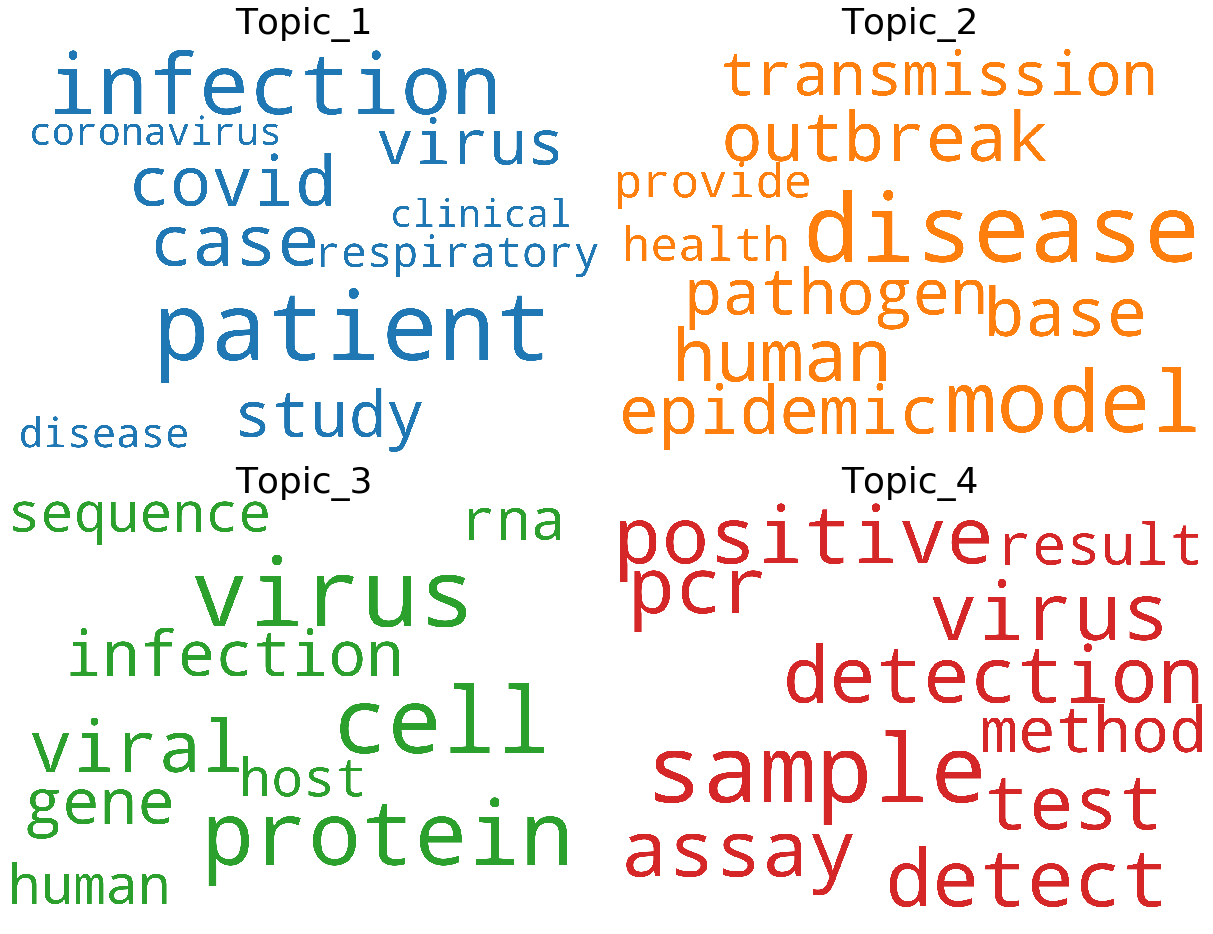

In [37]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=english_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(17,13), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic_' + str(i+1), fontdict=dict(size=36))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [40]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.sort_values('importance', ascending=False, inplace=True)
print(df.shape)
df.head()

(40, 4)


,word,topic_id,importance,word_count
0,patient,0,0.029769,16574
20,virus,2,0.024607,40750
1,infection,0,0.023133,27832
21,cell,2,0.022781,23985
22,protein,2,0.021441,18506


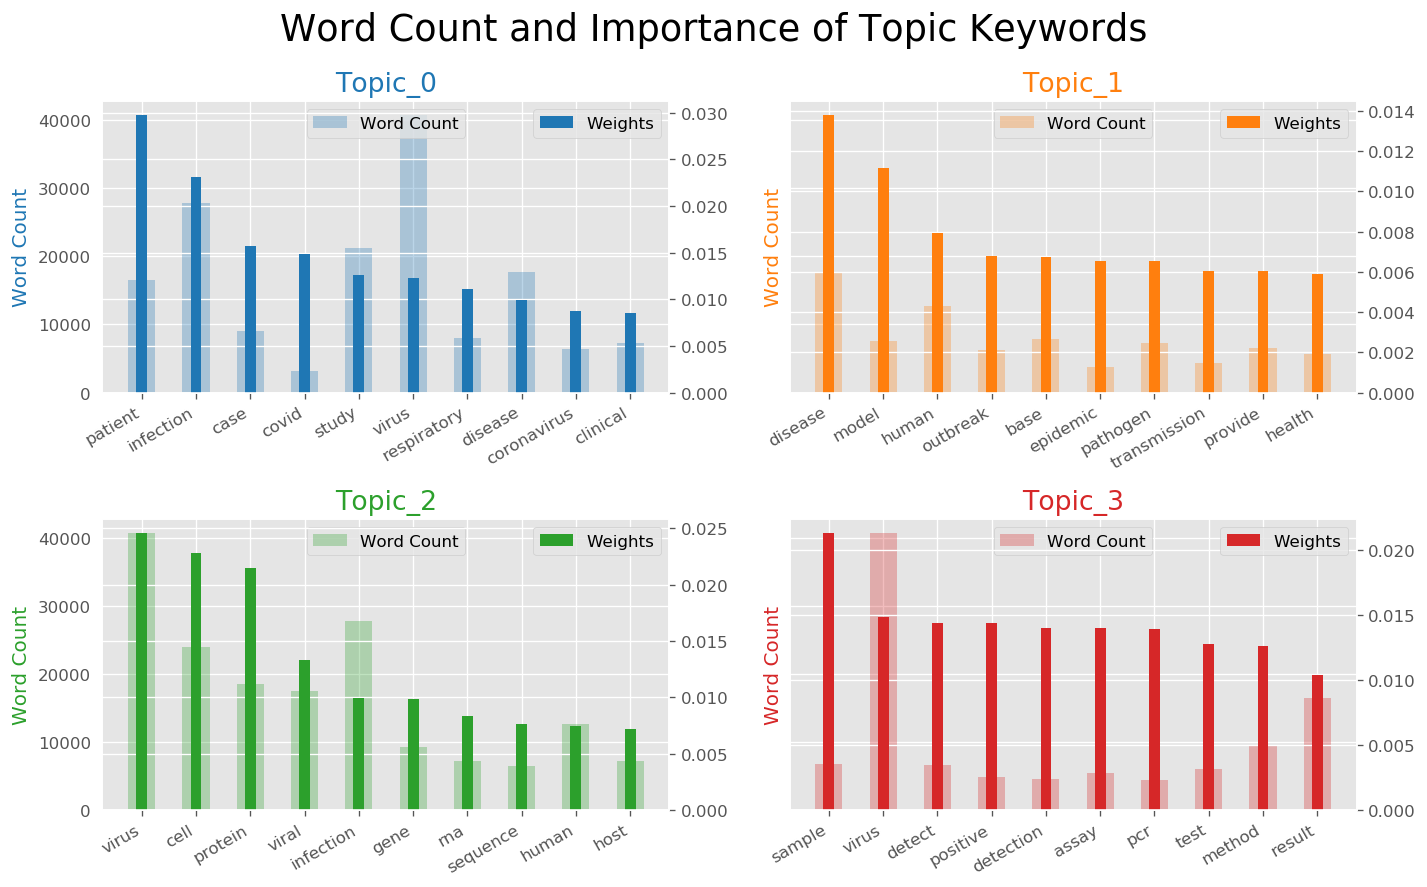

In [50]:
# Plot Word Count and Weights of Topic Keywords 
fig, axes = plt.subplots(2, 2, figsize=(12,7), sharey=True, dpi=120)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.040); ax.set_ylim(0, 40000)
    ax.set_title('Topic_' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [42]:
doc_lda = lda_model[corpus]
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=list(cord19_df.abstract.values)):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key=lambda x: (x[1]), reverse=True) 
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df) 


In [43]:
%%time
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['doc_id', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

df_dominant_topic.sort_values(by='topic_perc_contrib',  ascending=False, inplace=True)
df_dominant_topic.head(5)

,doc_id,dominant_topic,topic_perc_contrib,keywords,text
20096,20096,1.0,0.9955,"disease, model, human, outbreak, base, epidemic, pathogen, transmission, provide, health","[background, outbreak, wake, call, regard, critical, importance, resilient, health, system, frag..."
17207,17207,1.0,0.9955,"disease, model, human, outbreak, base, epidemic, pathogen, transmission, provide, health","[knowledge, management, field, concerned, management, knowledge, include, management, knowledge,..."
9711,9711,1.0,0.9952,"disease, model, human, outbreak, base, epidemic, pathogen, transmission, provide, health","[implement, national, community, base, health, strategy, human, animal, environmental, challenge..."
10510,10510,2.0,0.9945,"virus, cell, protein, viral, infection, gene, rna, sequence, human, host","[brome_mosaic, virus, protein, multiple, key, role, viral, rna, replication, localize, perinucle..."
9709,9709,1.0,0.9943,"disease, model, human, outbreak, base, epidemic, pathogen, transmission, provide, health","[unprecedented, globalization, trade, travel, climate_change, protectionism, geopolitical, popul..."


In [ ]:
print('The percentage of documents that dominated the topic has less than 80% contribution is: {}%'.format(
      round(len(df_dominant_topic.loc[df_dominant_topic.topic_perc_contrib<=0.50])/len(df_dominant_topic)*100,2)))

In [45]:
# Display setting to show more characters in column 
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['perc_contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index 
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format 
sent_topics_sorteddf_mallet.columns = ['no_topic', "topic_perc_contrib", "keywords", "representative text"]

# Show 
sent_topics_sorteddf_mallet

,no_topic,topic_perc_contrib,keywords,representative text
0,0.0,0.9942,"patient, infection, case, covid, study, virus, respiratory, disease, coronavirus, clinical","[background, outcome, severe, associate, pneumonia, adequately, evaluate, objective, aim, invest..."
1,1.0,0.9955,"disease, model, human, outbreak, base, epidemic, pathogen, transmission, provide, health","[knowledge, management, field, concerned, management, knowledge, include, management, knowledge,..."
2,2.0,0.9945,"virus, cell, protein, viral, infection, gene, rna, sequence, human, host","[brome_mosaic, virus, protein, multiple, key, role, viral, rna, replication, localize, perinucle..."
3,3.0,0.9709,"sample, virus, detect, positive, detection, assay, pcr, test, method, result","[objective, compare, laboratory, develop, real, pcr, assay, detection, mycoplasma, hominis, dete..."


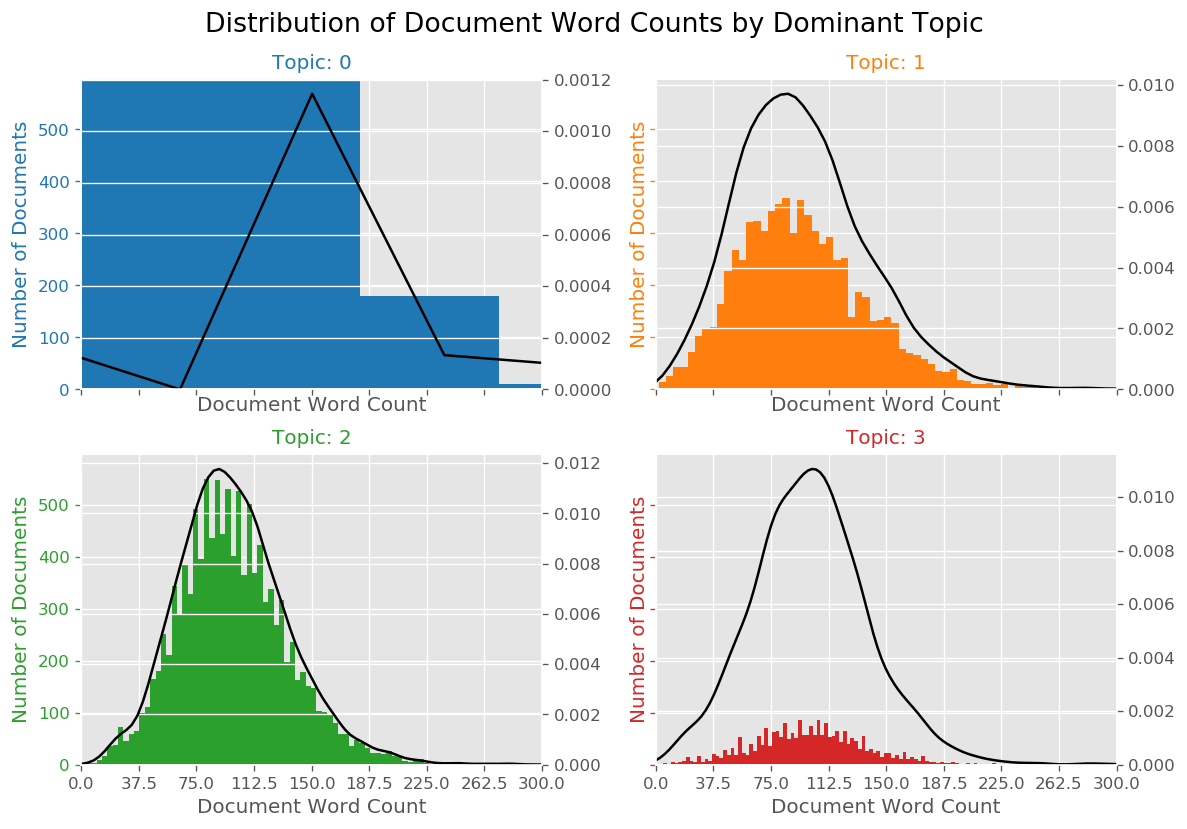

In [61]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2, figsize=(10,7), dpi=120, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.dominant_topic == i,:]
    doc_lens = [len(d) for d in df_dominant_topic_sub.text]
    ax.hist(doc_lens, bins = 120, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 300), ylim=(0, max(doc_lens)+300), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,300,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.show()

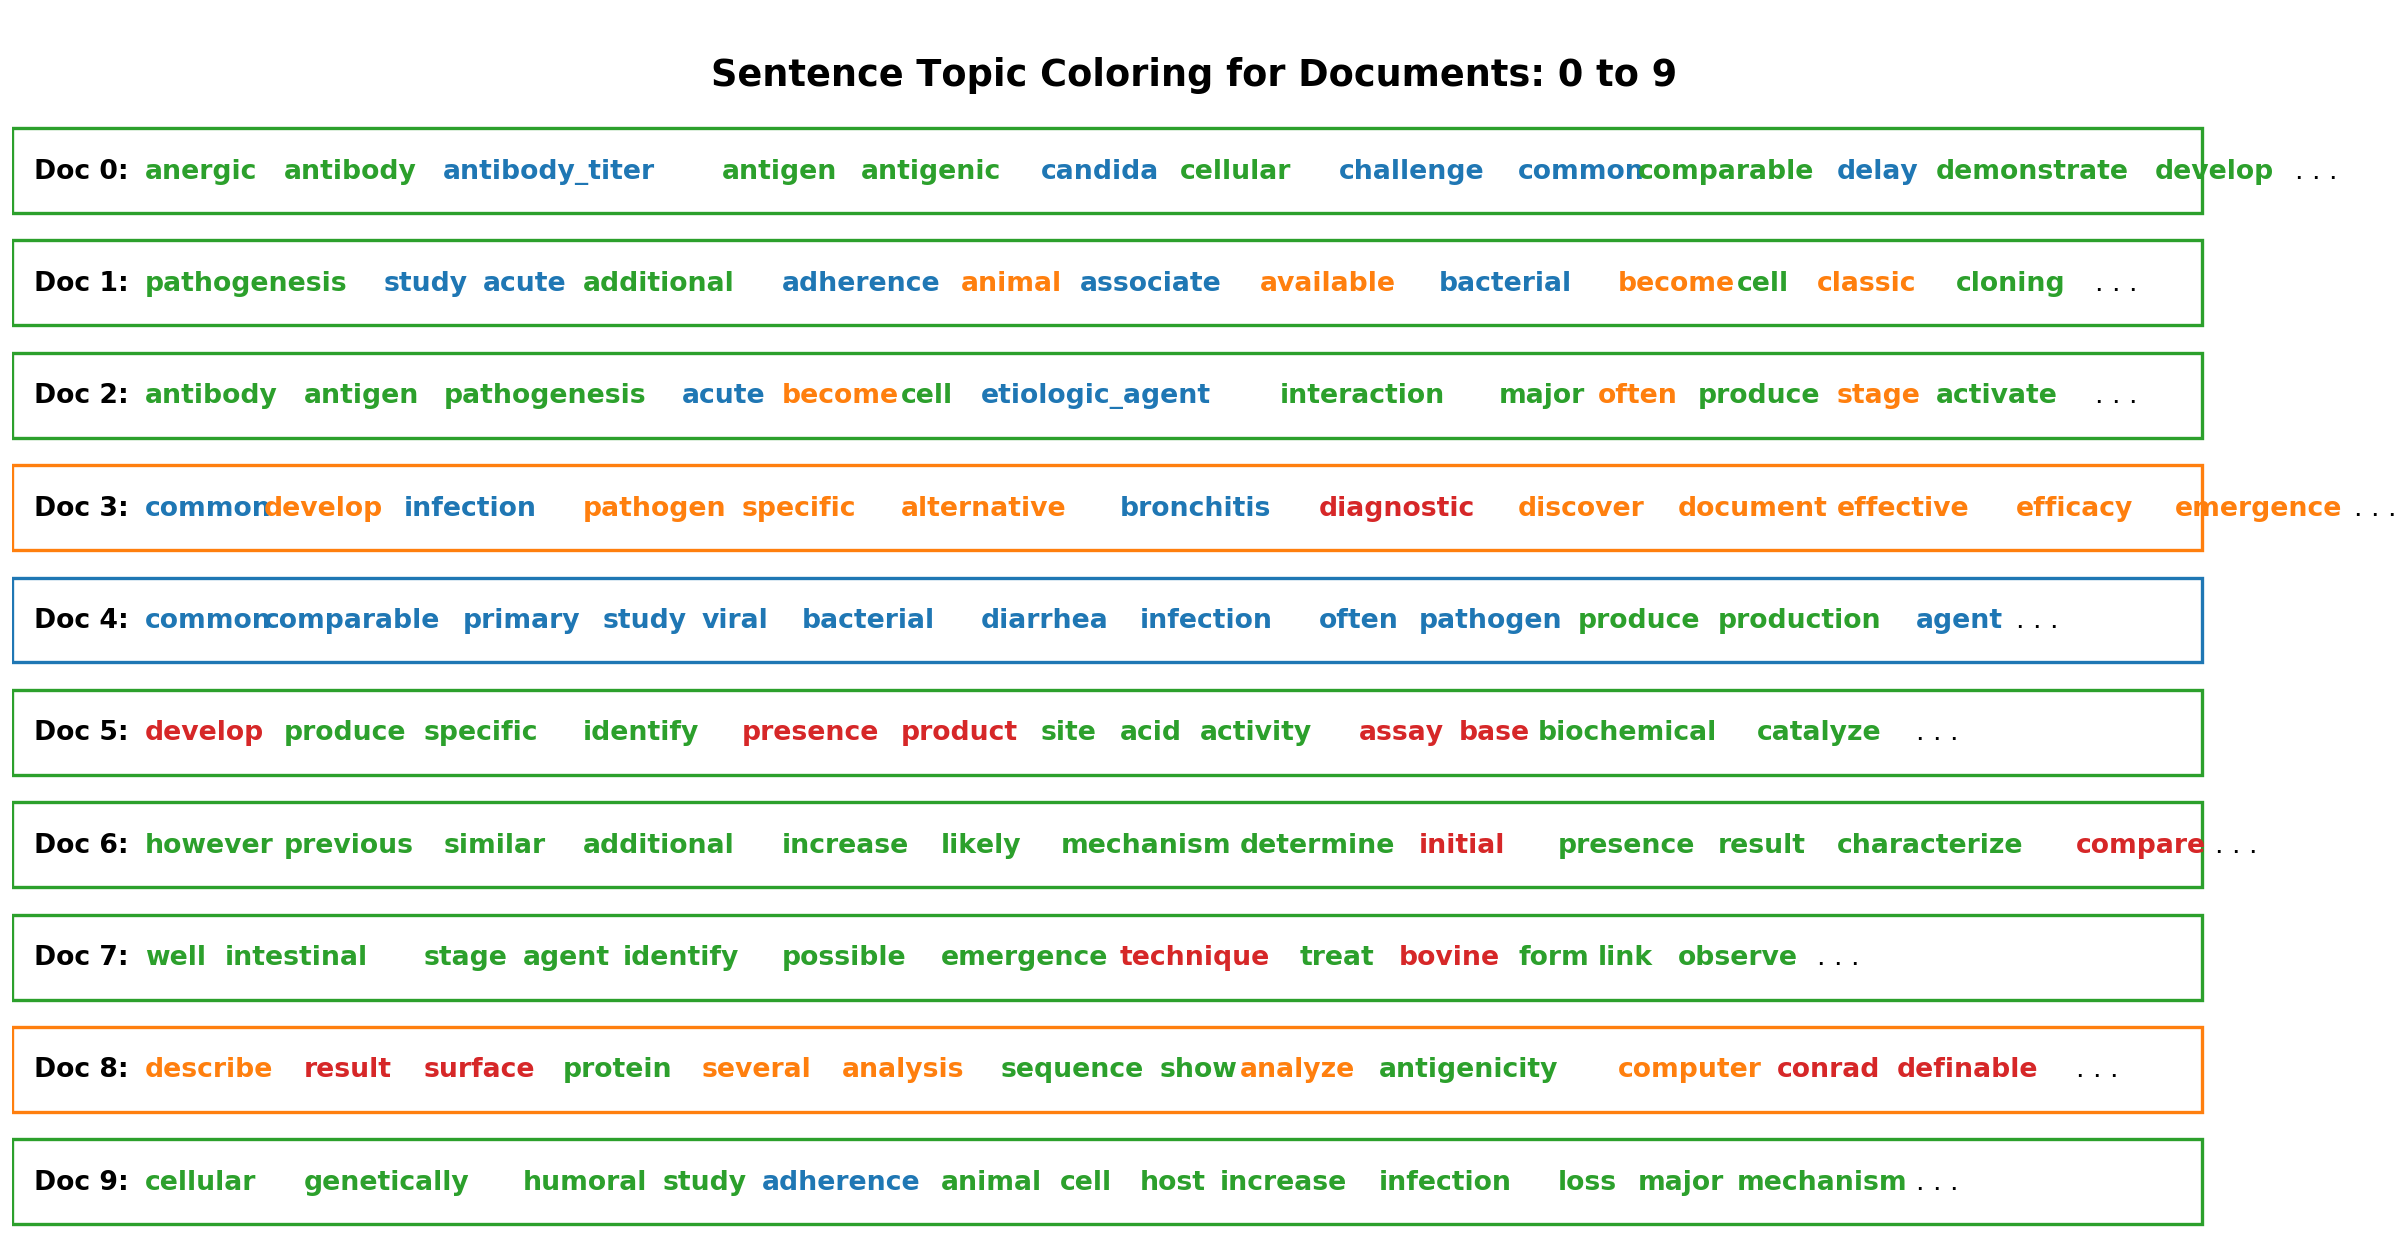

In [62]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=11):
    
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=120)       
    axes[0].axis('off')
    
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics] 
            
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)
            
            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            
            word_pos = 0.06 
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 13:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: '+str(start)+' to '+str(end-2),
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [64]:
%%time
import pyLDAvis.gensim
pyLDAvis.enable_notebook(local=False)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis 

CPU times: user 45 s, sys: 979 ms, total: 46 s
Wall time: 46.8 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.085446  0.266163       1        1  35.085056
1      0.117119 -0.122074       2        1  28.136522
0      0.100749 -0.129064       3        1  24.237103
3     -0.303315 -0.015026       4        1  12.541328, topic_info=           Term          Freq         Total Category  logprob  loglift
246     patient  20119.000000  20119.000000  Default  30.0000  30.0000
60         cell  22288.000000  22288.000000  Default  29.0000  29.0000
292     protein  20977.000000  20977.000000  Default  28.0000  28.0000
84    infection  25353.000000  25353.000000  Default  27.0000  27.0000
875      sample   7455.000000   7455.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1006  molecular   1360.986816   3748.055908   Topic4  -5.5489   1.0631
227    clinical   1494.168091   8065.454102   Topic4  -5.4555   0.3901
396        show   1513.795776  11087.407227   Topic4  -5.4425   0.0850
49        viral   1409.262451  18497.210938   Topic4  -5.5141  -0.4984
108    specific   1326.425171   6739.281250   Topic4  -5.5746   0.4507

[271 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5747      2  0.001554    accuracy
5747      4  0.997857    accuracy
8873      1  0.999504         ace
433       1  0.999600  activation
257       1  0.874340    activity
...     ...       ...         ...
1251      3  0.999429        week
50        1  0.301115        well
50        2  0.487368        well
50        3  0.115922        well
50        4  0.095424        well

[390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])